Skin cancer detection

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, load_sample_images

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#%load_ext autoreload
#%autoreload 2

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Get all the data in the directory data/validation (132 images), and reshape them
#val_generator = ImageDataGenerator().flow_from_directory(
#        val_data_dir, classes=['test'])

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
#val_images, val_labels = next(val_generator)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


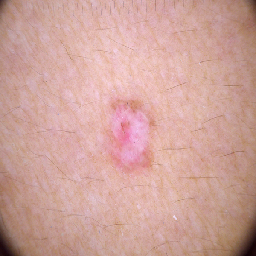

In [3]:
# Preview an image
array_to_img(train_images[0])

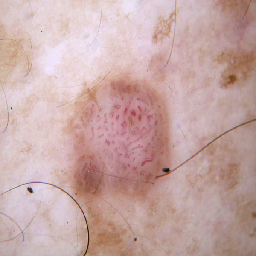

In [4]:
# Preview an image
array_to_img(test_images[0])

In [5]:
train_labels.shape

(2239, 9)

In [6]:
test_labels.shape

(118, 9)

In [7]:
test_images.shape

(118, 256, 256, 3)

In [8]:
train_images.shape

(2239, 256, 256, 3)

In [9]:
train_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [48]:
type(train_labels)

numpy.ndarray

In [49]:
type(train_images)

numpy.ndarray

In [10]:
dataframe=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

In [11]:
dataframe

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2236,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2237,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
sums=dataframe.sum(axis=0)

In [13]:
sums=pd.DataFrame(sums)

In [14]:
sums

,0
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


In [15]:
sums['%'] = ((sums[0] / 2239*100).round(2).astype(str) + '%')

In [16]:
sums

,0,%
actinic_keratosis,114.0,5.09%
basal_cell_carcinoma,376.0,16.79%
dermatofibroma,95.0,4.24%
melanoma,438.0,19.56%
nevus,357.0,15.94%
pigmented_benign_keratosis,462.0,20.63%
seborrheic_keratosis,77.0,3.44%
squamous_cell_carcinoma,181.0,8.08%
vascular_lesion,139.0,6.21%


In [17]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

In [18]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
print(train_img.shape)
print(test_img.shape)

(2239, 196608)
(118, 196608)


In [19]:
train_y = np.reshape(train_labels[:,0], (2239,1))
test_y = np.reshape(test_labels[:,0], (118,1))

In [20]:
X=train_img
y=train_y

In [21]:
model1 = Sequential()

In [22]:
model1.add(layers.Flatten())
model1.add(Dense(24, activation='relu', input_shape=(196608,)))
model1.add(Dense(12, activation='relu'))
model1.add(Dense(9, activation='softmax'))

In [23]:
model1.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
#model1.fit(X, y, epochs=50, batch_size=10)

The model did very well almost right away, 95% accuracy already at the fourth epoch.
Let us explore a bit more loss and accuracy using also a validation split.

In [25]:
results1 = model1.fit(X, y, epochs=20, batch_size=10, validation_split=0.2)

Epoch 1/50
180/180 [==============================] - 11s 57ms/step - loss: 1813.6498 - accuracy: 0.8465 - val_loss: 252.1391 - val_accuracy: 0.5714
Epoch 2/50
180/180 [==============================] - 9s 51ms/step - loss: 887.2385 - accuracy: 0.8749 - val_loss: 176.5087 - val_accuracy: 0.9420
Epoch 3/50
180/180 [==============================] - 9s 51ms/step - loss: 37.8180 - accuracy: 0.8900 - val_loss: 1.8896 - val_accuracy: 0.9420
Epoch 4/50
180/180 [==============================] - 9s 51ms/step - loss: 1.7504 - accuracy: 0.9509 - val_loss: 1.6193 - val_accuracy: 0.9420
Epoch 5/50
180/180 [==============================] - 9s 51ms/step - loss: 1.4878 - accuracy: 0.9509 - val_loss: 1.3698 - val_accuracy: 0.9420
Epoch 6/50
180/180 [==============================] - 9s 51ms/step - loss: 1.2474 - accuracy: 0.9509 - val_loss: 1.1449 - val_accuracy: 0.9420
Epoch 7/50
180/180 [==============================] - 9s 50ms/step - loss: 1.0330 - accuracy: 0.9509 - val_loss: 0.9478 - val_accur

In [26]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

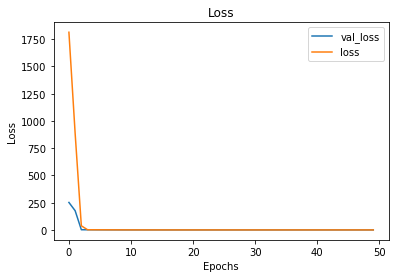

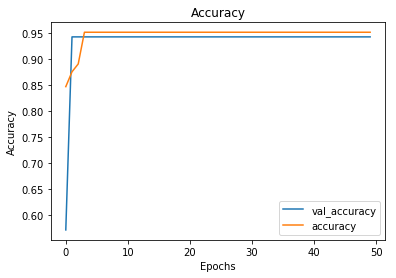

In [27]:
visualize_training_results(results1)

I just want to see out of curiosity what is the performance, with the same exact parameters, if I were to import the images in a smaller size.

In [28]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator64 = ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=10)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator64 = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=20)


# Create the datasets
train_images64, train_labels64 = next(train_generator64)
test_images64, test_labels64 = next(test_generator64)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [61]:
train_img64 = train_images64.reshape(train_images64.shape[0], -1)
test_img64 = test_images64.reshape(test_images64.shape[0], -1)
print(train_img64.shape)
print(test_img64.shape)

(20, 12288)
(10, 12288)


In [30]:
train_y64 = np.reshape(train_labels64[:,0], (20,1))
test_y64 = np.reshape(test_labels64[:,0], (10,1))

In [31]:
X64=train_img64
y64=train_y64

In [54]:
model2 = Sequential()

TypeError: __init__() got an unexpected keyword argument 'random_state'

In [33]:
model2.add(Dense(24, activation='relu', input_shape=(12288,)))
model2.add(Dense(12, activation='relu'))
model2.add(Dense(9, activation='softmax'))

In [53]:
model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

TypeError: Invalid keyword argument(s) in `compile`: {'random_state'}

In [35]:
#model2.fit(X64, y64, epochs=50, batch_size=10)

In [51]:
results2 = model2.fit(X64, y64, epochs=5, batch_size=10, validation_split=0.2)

TypeError: fit() got an unexpected keyword argument 'random_seed'

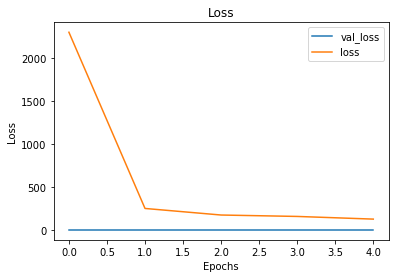

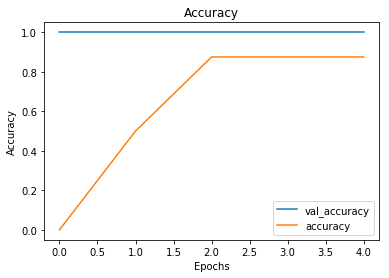

In [37]:
visualize_training_results(results2)

In [38]:
history2 = results2.history
history2

{'loss': [2300.59375,
  249.79730224609375,
  173.31521606445312,
  156.86351013183594,
  125.76715087890625],
 'accuracy': [0.0, 0.5, 0.875, 0.875, 0.875],
 'val_loss': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0]}

Look at lab on https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
might need to do some one hot encoding.
Also, just like it shows there, as a naive model maybe decrease the number of layers and keep epochs at like 5.
If results are the same, try to understand why the loss still showes such high peaks.And why the accuracy drops like that.
Might also be worth doing CNN from the start with 2D layers instead of this basic NN.

### Maybe another possible naive:

In [39]:
model3 = Sequential()
model3.add(Dense(12, activation='tanh', input_shape=(12288,)))
model3.add(Dense(9, activation='softmax'))

In [40]:
model3.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
results3 = model3.fit(X64, y64, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
2/2 [==============================] - 0s 137ms/step - loss: 2.4695 - accuracy: 0.0000e+00 - val_loss: 1.9591 - val_accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 0s 35ms/step - loss: 2.1373 - accuracy: 0.0000e+00 - val_loss: 1.8844 - val_accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 0s 37ms/step - loss: 2.0657 - accuracy: 0.0000e+00 - val_loss: 1.8230 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 0s 34ms/step - loss: 2.0060 - accuracy: 0.0000e+00 - val_loss: 1.7686 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 0s 34ms/step - loss: 1.9528 - accuracy: 0.0000e+00 - val_loss: 1.7188 - val_accuracy: 0.0000e+00


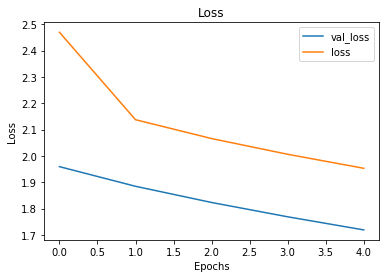

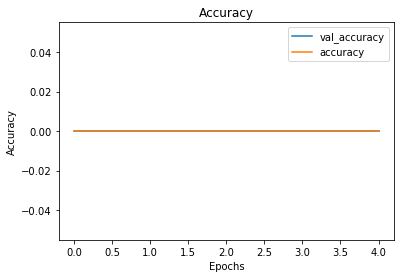

In [42]:
visualize_training_results(results3)

In [43]:
# changing batch size to 1
results4 = model3.fit(X64, y64, epochs=5, batch_size=1, validation_split=0.2)

Epoch 1/5
16/16 [==============================] - 0s 11ms/step - loss: 1.7700 - accuracy: 0.8125 - val_loss: 1.3963 - val_accuracy: 1.0000
Epoch 2/5
16/16 [==============================] - 0s 5ms/step - loss: 1.4990 - accuracy: 0.8750 - val_loss: 1.1355 - val_accuracy: 1.0000
Epoch 3/5
16/16 [==============================] - 0s 5ms/step - loss: 1.2770 - accuracy: 0.8750 - val_loss: 0.9176 - val_accuracy: 1.0000
Epoch 4/5
16/16 [==============================] - 0s 5ms/step - loss: 1.0939 - accuracy: 0.8750 - val_loss: 0.7381 - val_accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 0s 5ms/step - loss: 0.9441 - accuracy: 0.8750 - val_loss: 0.5906 - val_accuracy: 1.0000


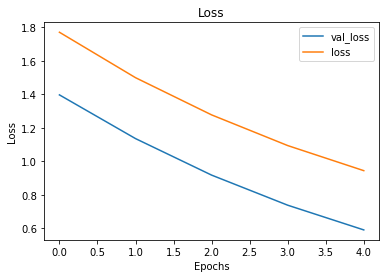

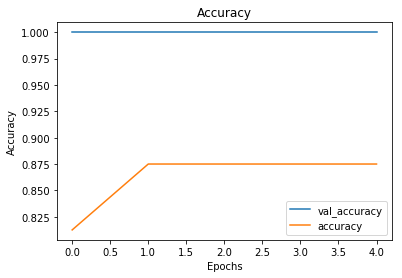

In [44]:
visualize_training_results(results4)

In [45]:
# increasing batch size to 20
results5 = model3.fit(X64, y64, epochs=5, batch_size=20, validation_split=0.2)

Epoch 1/5
1/1 [==============================] - 0s 55ms/step - loss: 0.8728 - accuracy: 0.8750 - val_loss: 0.5824 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 0s 27ms/step - loss: 0.8653 - accuracy: 0.8750 - val_loss: 0.5743 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 37ms/step - loss: 0.8580 - accuracy: 0.8750 - val_loss: 0.5662 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 31ms/step - loss: 0.8506 - accuracy: 0.8750 - val_loss: 0.5582 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 32ms/step - loss: 0.8434 - accuracy: 0.8750 - val_loss: 0.5502 - val_accuracy: 1.0000


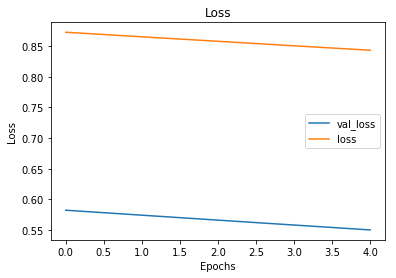

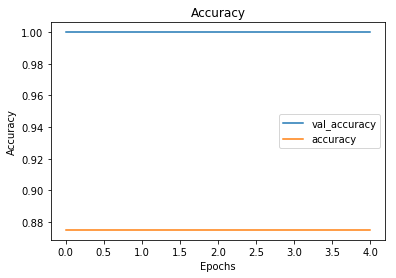

In [46]:
visualize_training_results(results5)

One more attempt at a naive model:
<br>since these ones keep performing even too well.
<br>I decrease again the size of the images, batch size and also number of neurons.

In [97]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator32= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=5)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator32 = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=10)


# Create the datasets
train_images32, train_labels32 = next(train_generator32)
test_images32, test_labels32 = next(test_generator32)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [98]:
train_img32 = train_images32.reshape(train_images32.shape[0], -1)
test_img32 = test_images32.reshape(test_images32.shape[0], -1)
print(train_img32.shape)
print(test_img32.shape)

(10, 3072)
(5, 3072)


In [99]:
train_y32 = np.reshape(train_labels32[:,0], (10,1))
test_y32 = np.reshape(test_labels32[:,0], (5,1))

In [100]:
X32=train_img32
y32=train_y32

In [101]:
model6 = Sequential()

In [86]:
model6.add(Dense(11, activation='relu', input_shape=(3072,)))
model6.add(Dense(10, activation='relu'))
model6.add(Dense(9, activation='softmax'))

In [87]:
model6.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [88]:
results6 = model6.fit(X32, y32, epochs=5, batch_size=5, validation_split=0.2)

Epoch 1/5
2/2 [==============================] - 1s 151ms/step - loss: 438.8934 - accuracy: 0.0000e+00 - val_loss: 570.5805 - val_accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 0s 32ms/step - loss: 394.8284 - accuracy: 0.0000e+00 - val_loss: 199.5381 - val_accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 0s 25ms/step - loss: 231.8654 - accuracy: 0.0000e+00 - val_loss: 615.4667 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 0s 26ms/step - loss: 454.9431 - accuracy: 0.1250 - val_loss: 131.4728 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 0s 36ms/step - loss: 114.2443 - accuracy: 0.0000e+00 - val_loss: 65.9593 - val_accuracy: 0.0000e+00


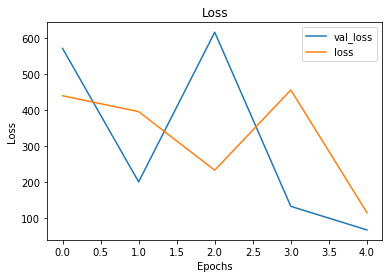

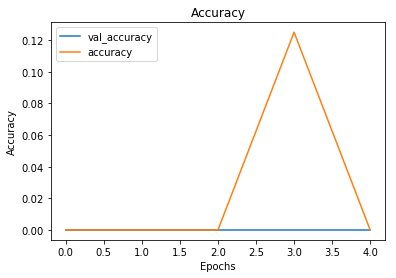

In [89]:
visualize_training_results(results6)

Even better, this does not make any sense.

Let us forget about all of this and try with the 2D actual convolutional neural network for images. The perfmormance there might be different.

We can also do something else which is group together the types of skin abnormalities that are cancerous and the ones that are not, reducing the classes to 2 and making this a binary classification problem.
I will do that later on. For now let's see what happens with a convolutional neural network, which is what I should be doing anyway.

## CNN

In [119]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [120]:
# Explore your dataset again
m_train = train_img.shape[0]
num_px = train_img.shape[1]
m_test = test_img.shape[0]
#m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
#print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_img.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img.shape))
print ("test_labels shape: " + str(test_lab.shape))
#print ("val_images shape: " + str(val_images.shape))
#print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 32, 32, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 32, 32, 3)
test_labels shape: (118, 9)


In [106]:
train_img = train_img.reshape(train_img.shape[0], -1)
test_img = test_img.reshape(test_img.shape[0], -1)
#val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
#print(val_img.shape)

(2239, 3072)
(118, 3072)


In [107]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [121]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(10, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [124]:
history = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=10, validation_split=0.2)

Epoch 1/30
180/180 [==============================] - 2s 9ms/step - loss: 0.2277 - acc: 0.9492 - val_loss: 0.2057 - val_acc: 0.9487
Epoch 2/30
180/180 [==============================] - 2s 8ms/step - loss: 0.2229 - acc: 0.9492 - val_loss: 0.2079 - val_acc: 0.9487
Epoch 3/30
180/180 [==============================] - 2s 9ms/step - loss: 0.2386 - acc: 0.9492 - val_loss: 0.2119 - val_acc: 0.9487
Epoch 4/30
180/180 [==============================] - 1s 8ms/step - loss: 0.2222 - acc: 0.9492 - val_loss: 0.3019 - val_acc: 0.9487
Epoch 5/30
180/180 [==============================] - 1s 8ms/step - loss: 0.2156 - acc: 0.9492 - val_loss: 0.2089 - val_acc: 0.9487
Epoch 6/30
180/180 [==============================] - 2s 8ms/step - loss: 0.2257 - acc: 0.9492 - val_loss: 0.2071 - val_acc: 0.9487
Epoch 7/30
180/180 [==============================] - 2s 9ms/step - loss: 0.2262 - acc: 0.9492 - val_loss: 0.2142 - val_acc: 0.9487
Epoch 8/30
180/180 [==============================] - 2s 9ms/step - loss: 0.

In [129]:
history.history

{'loss': [0.22765912115573883,
  0.22292940318584442,
  0.23861446976661682,
  0.22218941152095795,
  0.21556417644023895,
  0.22569000720977783,
  0.22620463371276855,
  0.29000124335289,
  0.214368999004364,
  0.25402843952178955,
  0.25417160987854004,
  0.2193813920021057,
  0.22823086380958557,
  0.25939756631851196,
  0.2217755913734436,
  0.24950851500034332,
  0.23912818729877472,
  0.2325034737586975,
  0.21838046610355377,
  0.24918042123317719,
  0.2541763484477997,
  0.22322383522987366,
  0.2235160917043686,
  0.24418514966964722,
  0.2506915032863617,
  0.21445748209953308,
  0.2277223914861679,
  0.21848852932453156,
  0.2262638807296753,
  0.2219391018152237],
 'acc': [0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,
  0.9491903781890869,


In [132]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

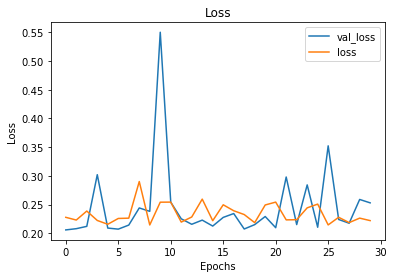

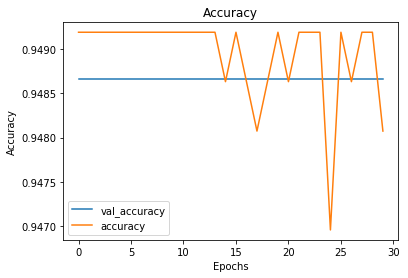

In [133]:
visualize_training_results(history)